In [1]:
from Scratch import metadata_loader
import numpy as np
from tqdm import tqdm

DEVICE = "ibm_sherbrooke"
LOGICAL = str(0)
XBASIS = False
ROUNDS = 50

state = "X" if XBASIS else "Z"
state += LOGICAL
print(f"state = {state}")


# Load the metadata
md = metadata_loader(True, True)
md = md[md["job_status"] == "JobStatus.DONE"]
md = md[md["code"] == "RepetitionCodeCircuit"]
md = md[md["descr"] == 'subset RepCodes']
md = md.dropna(subset=["rounds"])
md = md[md["meas_level"] == 1]
md['rounds'] = md['rounds'].astype(int)
md['distance'] = md['distance'].astype(int)

md = md[md["backend_name"] == DEVICE]
md = md[md["logical"] == LOGICAL]
md = md[md["xbasis"] == XBASIS]
md = md[md["rounds"] == ROUNDS]

# md = md[0:1]
print("shape:", md.shape)
md[:2]


state = Z0
shape: (40, 18)


,creation_date,notebook_name,backend_name,job_id,tags,meas_level,shots,num_qubits,job_status,execution_date,code,distance,rounds,logical,descr,resets,xbasis,path_info
5030,2024-03-23 14:05:45.787000+01:00,Sherbrooke_RepCodes_jobs,ibm_sherbrooke,cqzd7adk5z70008j0810,"[Subset 52, 50 rounds, 0 log, xbasis=False]",1.0,1507.0,NaN,JobStatus.DONE,2024-03-23 15:09:21.245239+01:00,RepetitionCodeCircuit,52,50,0,subset RepCodes,NaN,False,"{'mean_gate_error': 0.007733045348037, 'min_ga..."
5029,2024-03-23 14:05:37.855000+01:00,Sherbrooke_RepCodes_jobs,ibm_sherbrooke,cqzd78ds9z7g008dpaa0,"[Subset 52, 50 rounds, 0 log, xbasis=False]",1.0,1507.0,NaN,JobStatus.DONE,2024-03-23 15:08:51.313737+01:00,RepetitionCodeCircuit,52,50,0,subset RepCodes,NaN,False,"{'mean_gate_error': 0.007733045348037, 'min_ga..."


In [2]:
from result_saver import SaverProvider

provider = SaverProvider()

In [3]:
md_loc = 0

job_id = md.iloc[md_loc]["job_id"]
job = provider.retrieve_job(job_id) 

execution_date = job.result().date
memory = job.result().get_memory()

print(f"Execution date: {execution_date}")

Execution date: 2024-03-23 15:09:21.245239+01:00


In [4]:
# assert md_loc == -1
# for id in range(-5, -1):
#     job = provider.retrieve_job(md.iloc[id]["job_id"])
#     memory = np.vstack([memory, job.result().get_memory()])

assert md_loc == 0
for id in range(1, 5):
    job = provider.retrieve_job(md.iloc[id]["job_id"])
    memory = np.vstack([memory, job.result().get_memory()])

# Needed decoding objects

#### KDE

In [5]:
import numpy as np

_RESETS = False
SOFT_MUL = 0.5
T = md.iloc[md_loc]["rounds"]
d = md.iloc[md_loc]["distance"]

shots = md.iloc[md_loc]["shots"]

rel_error = 1

# KDE BANDWIDTHS
lin = [0.1, 0.7, 30]
num_points = 51
bandwidths = np.linspace(lin[0], lin[1], lin[2])

In [6]:
from soft_info import get_repcode_IQ_map
from soft_info import inv_qubit_mapping
from Scratch import load_calibration_memory
import cpp_soft_info
from datetime import datetime

all_memories, gmm_dict, msmt_err_dict = load_calibration_memory(provider, tobecalib_backend=DEVICE, 
                                                                other_date=execution_date, post_process=True,
                                                                double_msmt=False)
kde_dict = cpp_soft_info.get_KDEs(all_memories, bandwidths, relError=rel_error, absError=-1, num_points=num_points)

all_memories_PS, gmm_dict_PS, msmt_err_dict_PS = load_calibration_memory(provider, tobecalib_backend=DEVICE, 
                                                                other_date=execution_date, post_process=True,
                                                                double_msmt=True)

kde_dict_PS = cpp_soft_info.get_KDEs(all_memories_PS, bandwidths, relError=rel_error, absError=-1, num_points=num_points)

Found jobs for backend ibm_sherbrooke with closest execution date 2024-03-23 14:09:53.452291+00:00.
Found jobs for backend ibm_sherbrooke with closest execution date 2024-03-23 10:46:40.066413+00:00.


In [7]:
# Get the layout of the last job (same as previous)
layout_des = job.deserialize_layout(job.initial_layouts()[0]) # only 1 layout
link_qubits = list(layout_des['link_qubit'].values())
code_qubits = list(layout_des['code_qubit'].values())

# Get the pSoft and countMat matrices
big_layout = link_qubits + code_qubits
inverted_q_map = inv_qubit_mapping(get_repcode_IQ_map(big_layout, synd_rounds=T))

pSoft, countMat = cpp_soft_info.iqConvertor(memory, inverted_q_map, kde_dict, rel_error, -1, handleOutliers=True)

#### KDE_PS

In [8]:
pSoftPS, countMatPS = cpp_soft_info.iqConvertor(memory, inverted_q_map, kde_dict_PS, rel_error, -1, handleOutliers = True)

#### Gaussian

In [9]:
from soft_info import gaussianIQConvertor

countMatG, pSoftG = gaussianIQConvertor(memory, inverted_q_map, gmm_dict)
print(pSoftG.shape[0]*pSoftG.shape[1])

19606070


In [10]:
# post select high pSoftPS
print(pSoftPS.shape[0]*pSoftPS.shape[1])

pSoftPSPS = pSoftPS[pSoftPS != 0.5]
print(pSoftPSPS.shape[0])


19606070
19606070


In [16]:
print(np.max(pSoftPS))
print(np.max(pSoft))

# print how many entries are bigger than 0.5
print(np.sum(pSoftPS > 0.5))
print(np.sum(pSoft > 0.5))

print()
print(np.sum(pSoftPS == 0))
print(np.sum(pSoft == 0))
print(np.sum(pSoftG == 0))

print(np.min(pSoftPS))
print(np.min(pSoft))
print(np.min(pSoftG))

0.49999874434252833
0.49999909406811943
0
0

0
0
0
1.575539083360946e-15
4.871000039208717e-15
8.321508194549665e-70


# Statistics pSoft

0.5802342833114841 3.766482417061297


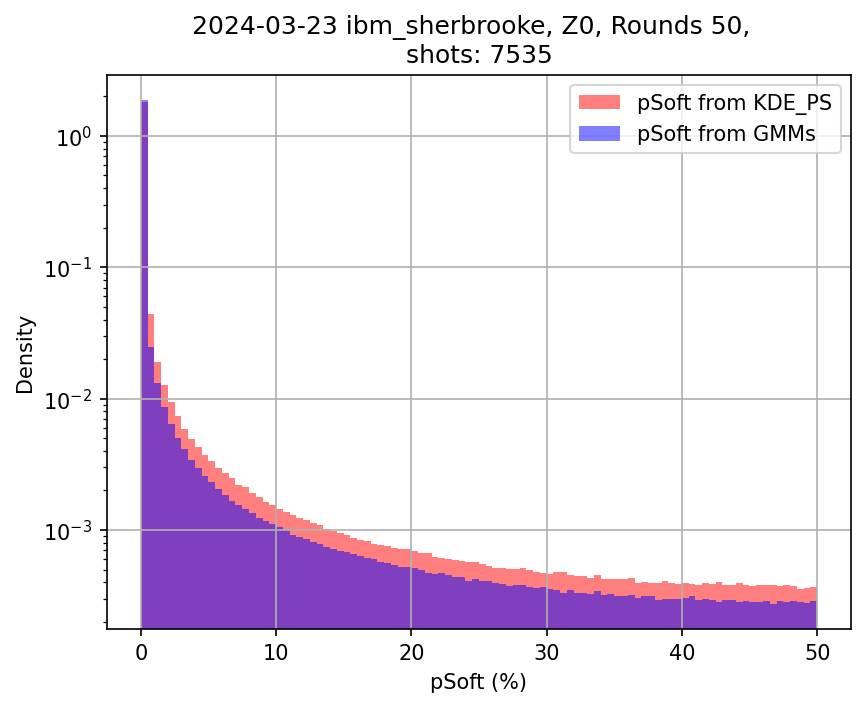

In [12]:
import numpy as np
import matplotlib.pyplot as plt

data1 = pSoft.flatten() * 100  
mean1 = np.mean(data1)  
std1 = np.std(data1)  

data2 = pSoftG.flatten() * 100  
mean2 = np.mean(data2)
std2 = np.std(data2)
print(mean2, std2)

data3 = pSoftPS.flatten() * 100  
mean3 = np.mean(data3)
std3 = np.std(data3)

plt.figure(dpi=150)

bins = 100
alpha = 0.5
density = True
# plt.hist(data1, bins=bins, density=density, alpha=alpha, color='g', label='pSoft from KDEs')
plt.hist(data3, bins=bins, density=density, alpha=alpha, color='r', label='pSoft from KDE_PS')
plt.hist(data2, bins=bins, density=density, alpha=alpha, color='b', label='pSoft from GMMs')  


plt.ylabel("Density")
plt.xlabel("pSoft (%)")
plt.grid()

# # Plot the means as vertical lines
# plt.axvline(mean1, color='green', linestyle='dashed', linewidth=1, label=f'Mean: {mean1:.2f}%')
# plt.axvline(mean3, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean3:.2f}%')
# plt.axvline(mean2, color='blue', linestyle='dashed', linewidth=1, label=f'Mean: {mean2:.2f}%')  

# # Plot the standard deviations as error bars
# plt.errorbar(mean1, plt.ylim()[1] * 0.9, xerr=std1, fmt='o', color='green', capsize=5, label=f'Std: {std1:.2f}')
# plt.errorbar(mean3, plt.ylim()[1] * 0.7, xerr=std3, fmt='o', color='red', capsize=5, label=f'Std: {std3:.2f}')
# plt.errorbar(mean2, plt.ylim()[1] * 0.8, xerr=std2, fmt='o', color='blue', capsize=5, label=f'Std: {std2:.2f}')  

# plt.ylim(0, 0.02)
# plt.xlim(0, 0.15)

plt.yscale('log')

date_str = md.iloc[md_loc]['execution_date']
execution_date = datetime.fromisoformat(date_str)
formatted_date = execution_date.strftime('%Y-%m-%d')
plt.title(f"{formatted_date} {DEVICE}, {state}, Rounds {ROUNDS},  \nshots: {memory.shape[0]}")
plt.legend()
plt.show()


In [13]:
# # Compare with the mean errors 

# p_soft = 0
# p_hard = 0
# for k, v in msmt_err_dict_PS.items():
#     p_soft += v["p_soft"]
#     p_hard += v["p_hard"]

# p_soft /= len(msmt_err_dict_PS)
# p_hard /= len(msmt_err_dict_PS)

# print(f"p_soft: {p_soft}, p_hard: {p_hard}")

# Sample from data

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Let's assume 'data' is the array from which the histogram was created
data = pSoftPS.flatten()

# Compute the histogram
count, bin_edges = np.histogram(data, bins=100)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Normalize the histogram to create a PMF
pmf = count / np.sum(count)

# Compute the CDF from the PMF
cdf = np.cumsum(pmf)

def sample_from_histogram(bin_centers, cdf, size=1):
    # Generate uniform random numbers
    random_numbers = np.random.rand(size)
    # Find the bin corresponding to each random number
    sampled_indices = np.searchsorted(cdf, random_numbers)
    # Return the sampled bin centers
    return bin_centers[sampled_indices]

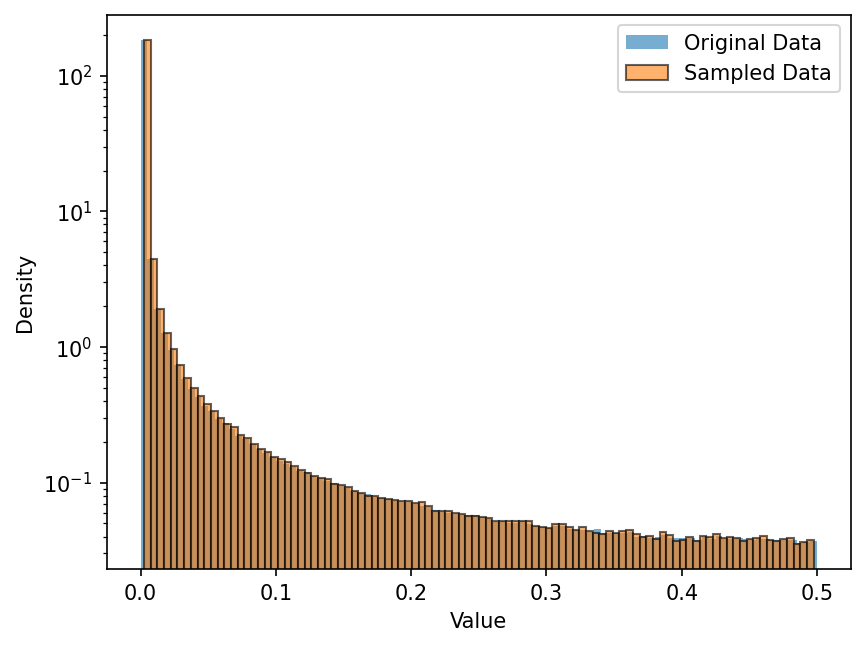

In [15]:

# Sample from the histogram
sampled_data = sample_from_histogram(bin_centers, cdf, size=int(5e6))

# Plot the original histogram and the sampled data
plt.figure(dpi=150)
plt.hist(data, bins=100, density=True, alpha=0.6, label='Original Data')
plt.hist(sampled_data, bins=100, density=True, alpha=0.6, label='Sampled Data', edgecolor='black')
plt.yscale('log')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()